In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, lit, udf, greatest, mean as _mean, stddev as _stddev, max as spark_max, expm1, row_number
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import PipelineModel


In [ ]:
spark = SparkSession.builder \
    .appName("PredictionVisualisation") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.4.1") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.mongodb.read.connection.uri", "mongodb://namenode:27017/air_quality_db.predictions") \
    .getOrCreate()

parquet_path = "hdfs://namenode:9000/user/hadoop/dane_przetworzone/meteo_gios_model_ready_log.parquet"
df_offline = spark.read.parquet(parquet_path)

df_offline.show(5)

pdf_offline = df_offline.toPandas()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-71c3ed1c-b324-404a-bea8-5a42e488826d;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.4.1 in central
	found org.mongodb#mongodb-driver-sync;5.1.4 in central
	[5.1.4] org.mongodb#mongodb-driver-sync;[5.1.1,5.1.99)
	found org.mongodb#bson;5.1.4 in central
	found org.mongodb#mongodb-driver-core;5.1.4 in central
	found org.mongodb#bson-record-codec;5.1.4 in central
:: resolution report :: resolve 1541ms :: artifacts dl 13ms
	:: modules in use:
	org.mongodb#bson;5.1.4 from central in [default]
	org.mongodb#bson-record-codec;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-core;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-sync;5.1.4 from central in [default]
	org.mongodb.spark#mongo-spark-connector

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+------+-------+-------+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       datetime_utc|temperature|humidity|dew_point|rain|snowfall|pressure|cloud_cover|wind_speed|wind_dir| no2|    o3|   pm10|   pm25|so2|hour|day_of_week|month|year|pm10_t-1|pm10_t+1|pm25_t-1|pm25_t+1|no2_t-1|no2_t+1|o3_t-1|o3_t+1|so2_t-1|so2_t+1|           log_no2|            log_o3|          log_pm10|          log_pm25|           log_so2|      log_pm10_t-1|      log_pm10_t+1|      log_pm25_t-1|      log_pm25_t+1|       log_no2_t-1|       log_no2_t+1|       

In [ ]:
parquet_path = "hdfs://namenode:9000/user/hadoop/dane_przetworzone/online_training_dataset_with_offline_preds_final.parquet"
df_online = spark.read.parquet(parquet_path)

df_online.show(5)

pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']
percentiles_98 = {}

for pol in pollutants:
    q = df_online.approxQuantile(pol, [0.98], 0.00)
    percentiles_98[pol] = q[0]
    print(f"{pol}: 98. percentyl = {q[0]:.2f}")

all_cols = df_online.columns
cols_to_check = []

for pol in pollutants:
    for c in all_cols:
        if c == pol or c.startswith(pol + '_t'):
            cols_to_check.append((c, pol))

from functools import reduce

filter_condition = reduce(
    lambda acc, pair: acc & (col(pair[0]) <= percentiles_98[pair[1]]),
    cols_to_check,
    col(cols_to_check[0][0]) <= percentiles_98[cols_to_check[0][1]]
)

df_online = df_online.filter(filter_condition)
print(f"Liczba rekordów po filtracji: {df_online.count()}")

pdf_online = df_online.toPandas()

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+----+---+----+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+------------------------

In [ ]:
OFFLINE_MODELS_BASE_PATH = "hdfs://namenode:9000/user/hadoop/modele/offline_cv"
ONLINE_MODELS_BASE_PATH = "hdfs://namenode:9000/user/hadoop/modele/online_cv"

POLLUTANTS = ["pm10", "pm25", "no2", "o3", "so2"]

OFFLINE_MODEL_PATHS = {p: f"{OFFLINE_MODELS_BASE_PATH}/offline_rf_{p}" for p in POLLUTANTS}
ONLINE_MODEL_PATHS = {p: f"{ONLINE_MODELS_BASE_PATH}/online_rf_{p}" for p in POLLUTANTS}

loaded_offline_models = {}
loaded_online_models = {}

print("Ładowanie modeli OFFLINE...")
for pollutant, path in OFFLINE_MODEL_PATHS.items():
    try:
        loaded_offline_models[pollutant] = PipelineModel.load(path)
        print(f"Załadowano model offline dla {pollutant} z {path}")
    except Exception as e:
        print(f"Nie udało się załadować modelu offline dla {pollutant} z {path}: {e}")
        loaded_offline_models[pollutant] = None

print("\nŁadowanie modeli ONLINE...")
for pollutant, path in ONLINE_MODEL_PATHS.items():
    try:
        loaded_online_models[pollutant] = PipelineModel.load(path)
        print(f"Załadowano model online dla {pollutant} z {path}")
    except Exception as e:
        print(f"Nie udało się załadować modelu online dla {pollutant} z {path}: {e}")
        loaded_online_models[pollutant] = None

In [ ]:
OFFLINE_MODEL_FEATURE_COLS = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

ONLINE_MODEL_BASE_FEATURE_COLS = [
    "temperature", "humidity", "dew_point", "rain", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

traffic_cols = [col for col in df_online.columns if col.startswith("trafficJamRatio")]

excluded_traffic_cols = [
    'trafficJamRatio_52-1882_20-9135', 'trafficJamRatio_52-1934_20-9244', 'trafficJamRatio_52-2014_20-9366',
    'trafficJamRatio_52-2037_20-9065', 'trafficJamRatio_52-2051_20-9105', 'trafficJamRatio_52-2072_20-9073',
    'trafficJamRatio_52-2077_20-9040', 'trafficJamRatio_52-2081_20-9073', 'trafficJamRatio_52-2089_20-9057',
    'trafficJamRatio_52-2089_20-9071', 'trafficJamRatio_52-2096_20-9078'
]

traffic_feature_names_filtered = [col for col in traffic_cols if col not in excluded_traffic_cols]

ONLINE_MODEL_FEATURE_COLS = ONLINE_MODEL_BASE_FEATURE_COLS + traffic_feature_names_filtered


ALL_MODEL_COLS = OFFLINE_MODEL_FEATURE_COLS.copy()
for model_col in ONLINE_MODEL_FEATURE_COLS:
    if model_col not in ALL_MODEL_COLS:
        ALL_MODEL_COLS.append(model_col)

In [ ]:
df_offline_with_preds = df_offline

for pollutant, model in loaded_offline_models.items():
    if model is not None:
        pred_df = model.transform(df_offline_with_preds)

        pred_col_name = f"{pollutant}_offline_pred"

        pred_values = pred_df.select("prediction")

        df_offline_with_preds = pred_df.withColumnRenamed("prediction", pred_col_name).drop(*[c for c in pred_df.columns if c not in df_offline_with_preds.columns and c != pred_col_name])

    else:
        print(f"Model offline dla {pollutant} nie został załadowany, pomijam predykcję.")

df_offline_with_preds.show()

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+------+-------+-------+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       datetime_utc|temperature|humidity|dew_point|rain|snowfall|pressure|cloud_cover|wind_speed|wind_dir| no2|    o3|   pm10|   pm25|so2|hour|day_of_week|month|year|pm10_t-1|pm10_t+1|pm25_t-1|pm25_t+1|no2_t-1|no2_t+1|o3_t-1|o3_t+1|so2_t-1|so2_t+1|           log_no2|            log_o3|          log_pm10|          log_pm25|           log_so2|      log_pm10_t-1|      l

In [ ]:
df_online_with_preds = df_online

for pollutant, model in loaded_online_models.items():
    if model is not None:
        pred_df = model.transform(df_online_with_preds)

        pred_col_name = f"{pollutant}_online_pred"

        df_online_with_preds = pred_df.withColumnRenamed("prediction", pred_col_name).drop(
            *[c for c in pred_df.columns if c not in df_online_with_preds.columns and c != pred_col_name]
        )
    else:
        print(f"Model online dla {pollutant} nie został załadowany – pomijam.")

df_online_with_preds.show()

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+----+----+----+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-----------------------

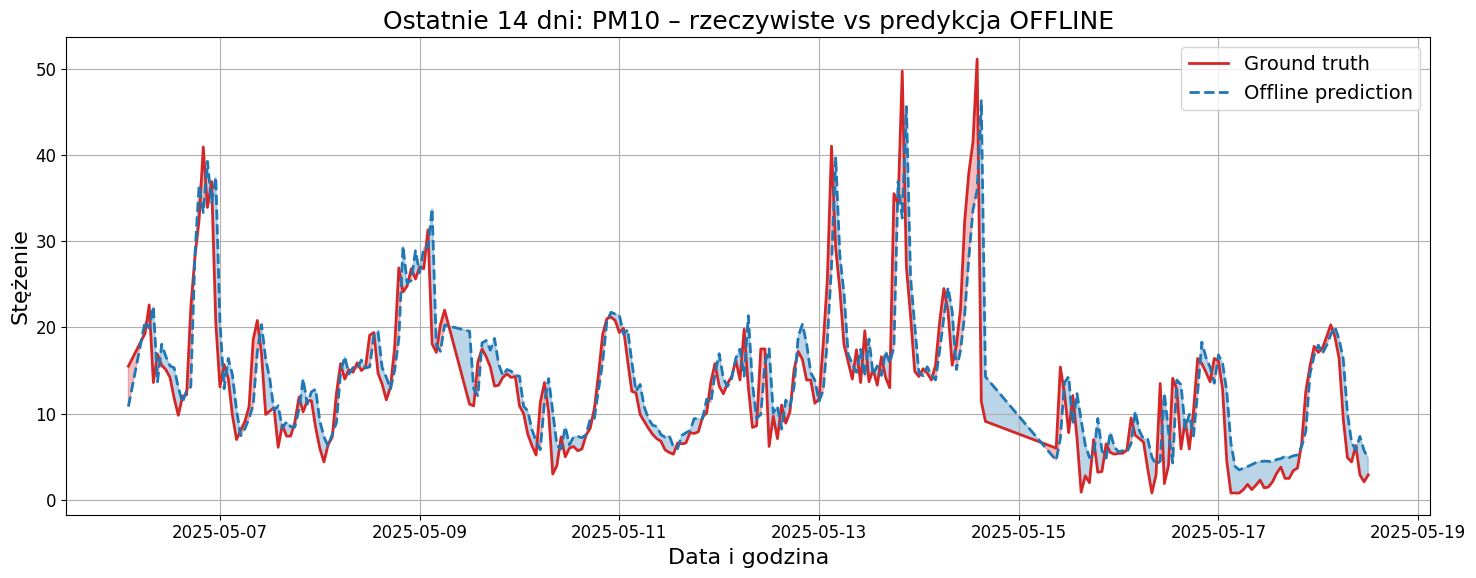

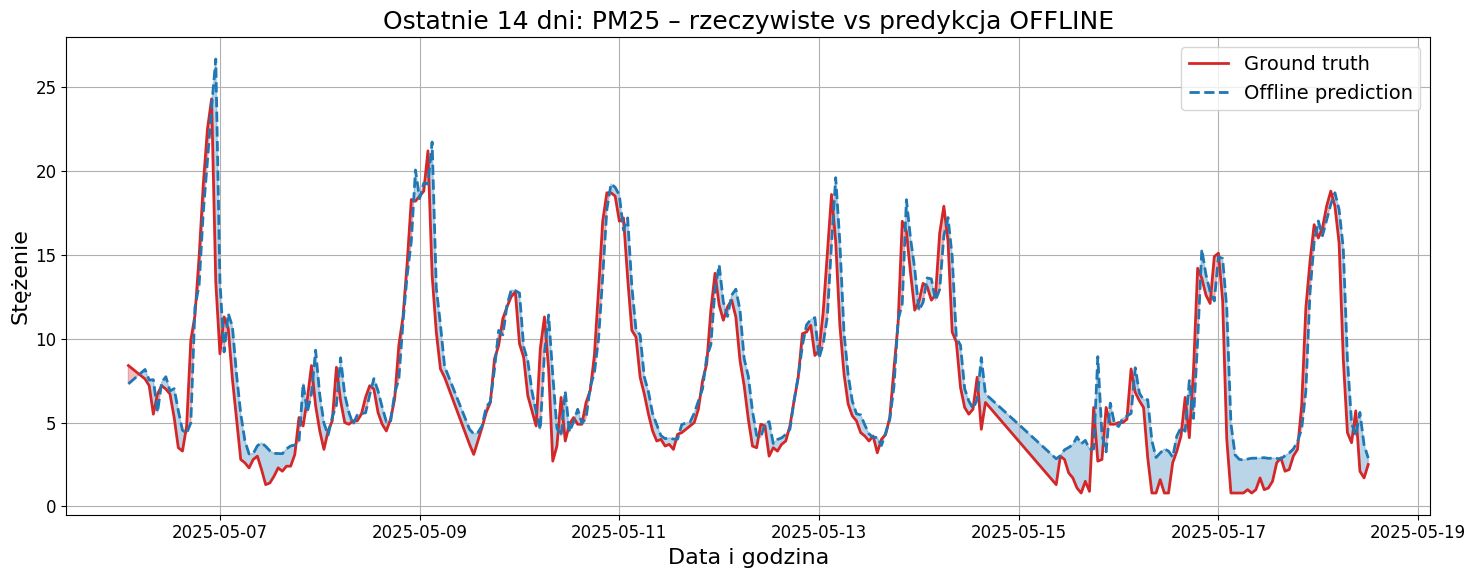

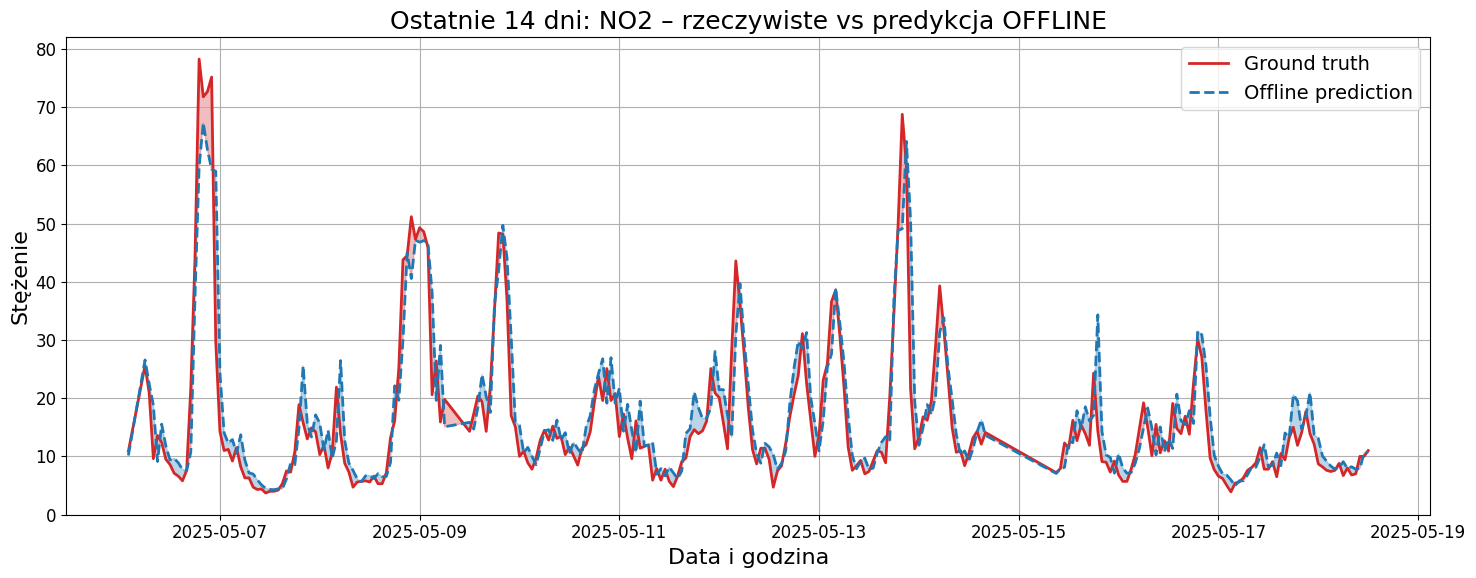

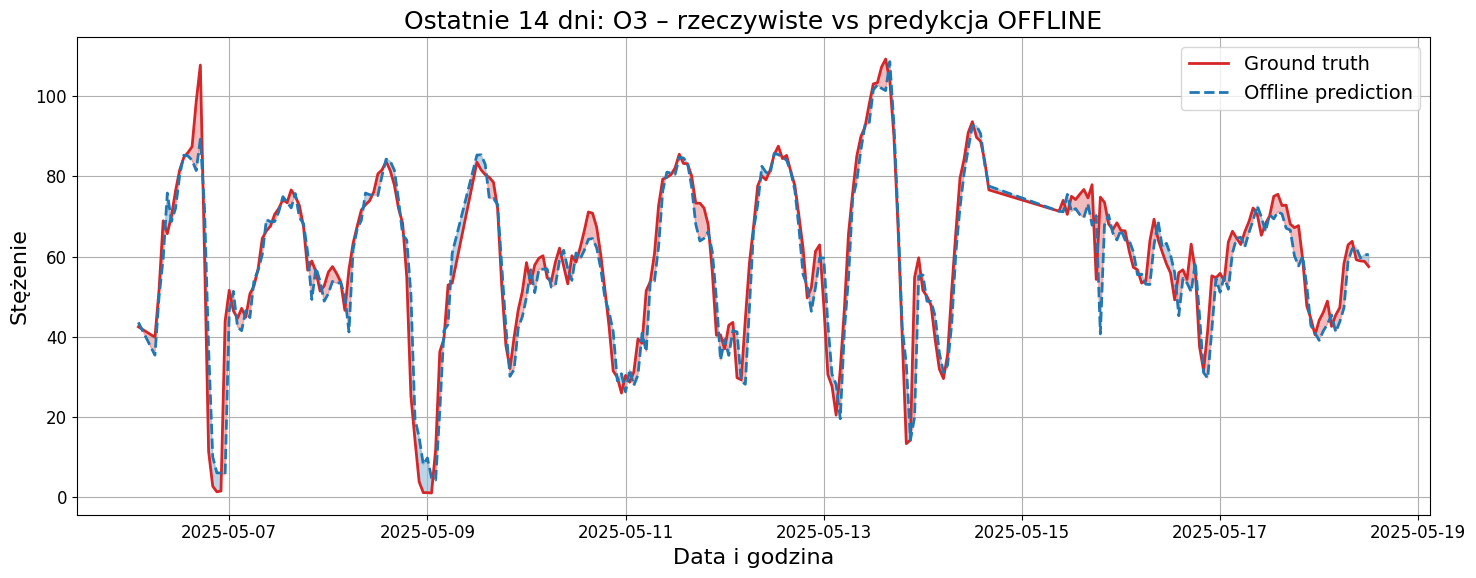

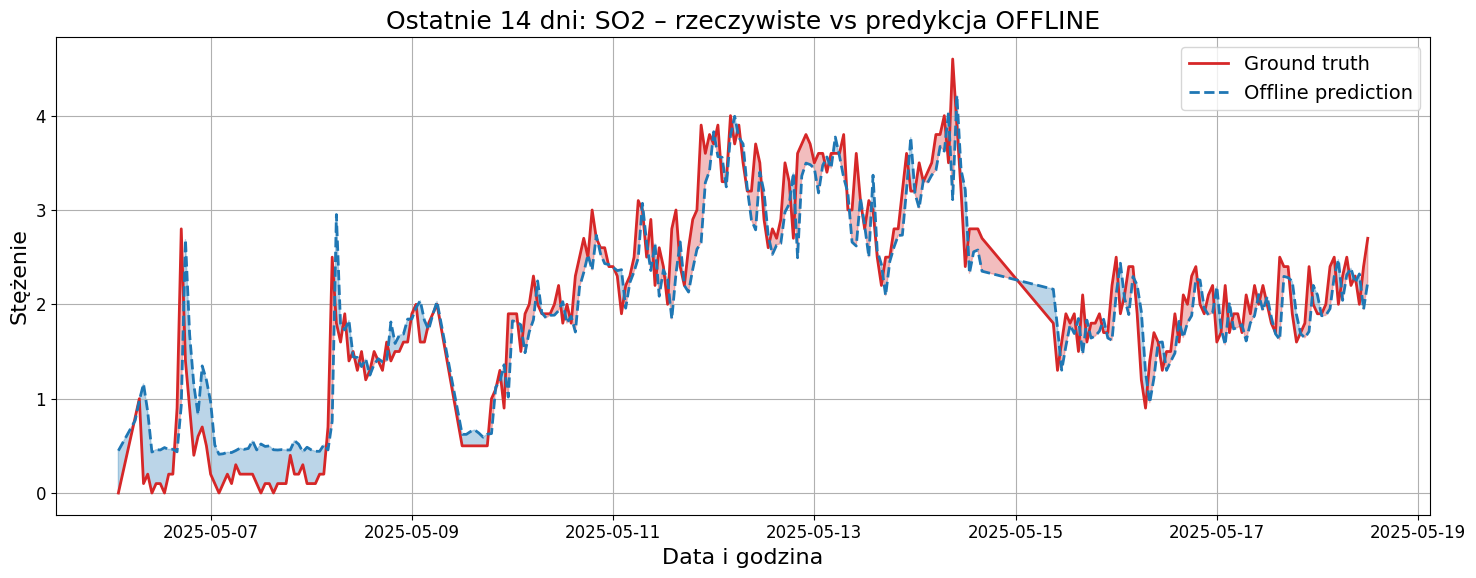

In [ ]:
selected_cols = ["datetime_utc"] + POLLUTANTS + [f"{p}_t+1" for p in POLLUTANTS] + [f"{p}_offline_pred" for p in POLLUTANTS]
selected_cols = [c for c in selected_cols if c in df_offline_with_preds.columns]
df_pd = df_offline_with_preds.select(*selected_cols).toPandas()
df_pd["datetime_utc"] = pd.to_datetime(df_pd["datetime_utc"])
df_pd = df_pd.sort_values("datetime_utc")
df_pd.set_index("datetime_utc", inplace=True)

last_14_days_df = df_pd[df_pd.index >= df_pd.index.max() - pd.Timedelta(days=14)]

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14
})

colors = {
    "gt": "#D62728",
    "pred": "#1F77B4"
}

for pollutant in POLLUTANTS:
    gt_col = f"{pollutant}_t+1"
    pred_col = f"{pollutant}_offline_pred"

    if gt_col in last_14_days_df.columns and pred_col in last_14_days_df.columns:
        plt.figure(figsize=(15, 6))

        x = last_14_days_df.index
        y1 = last_14_days_df[gt_col]
        y2 = last_14_days_df[pred_col]

        plt.plot(x, y1, label="Ground truth", color=colors["gt"], linewidth=2)
        plt.plot(x, y2, label="Offline prediction", color=colors["pred"], linestyle="--", linewidth=2)

        plt.fill_between(x, y1, y2, where=(y2 > y1), interpolate=True, color=colors["pred"], alpha=0.3)

        plt.fill_between(x, y1, y2, where=(y1 > y2), interpolate=True, color=colors["gt"], alpha=0.3)

        plt.title(f"Ostatnie 14 dni: {pollutant.upper()} – rzeczywiste vs predykcja OFFLINE")
        plt.xlabel("Data i godzina")
        plt.ylabel("Stężenie")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Brakuje danych dla {pollutant} – pomijam.")

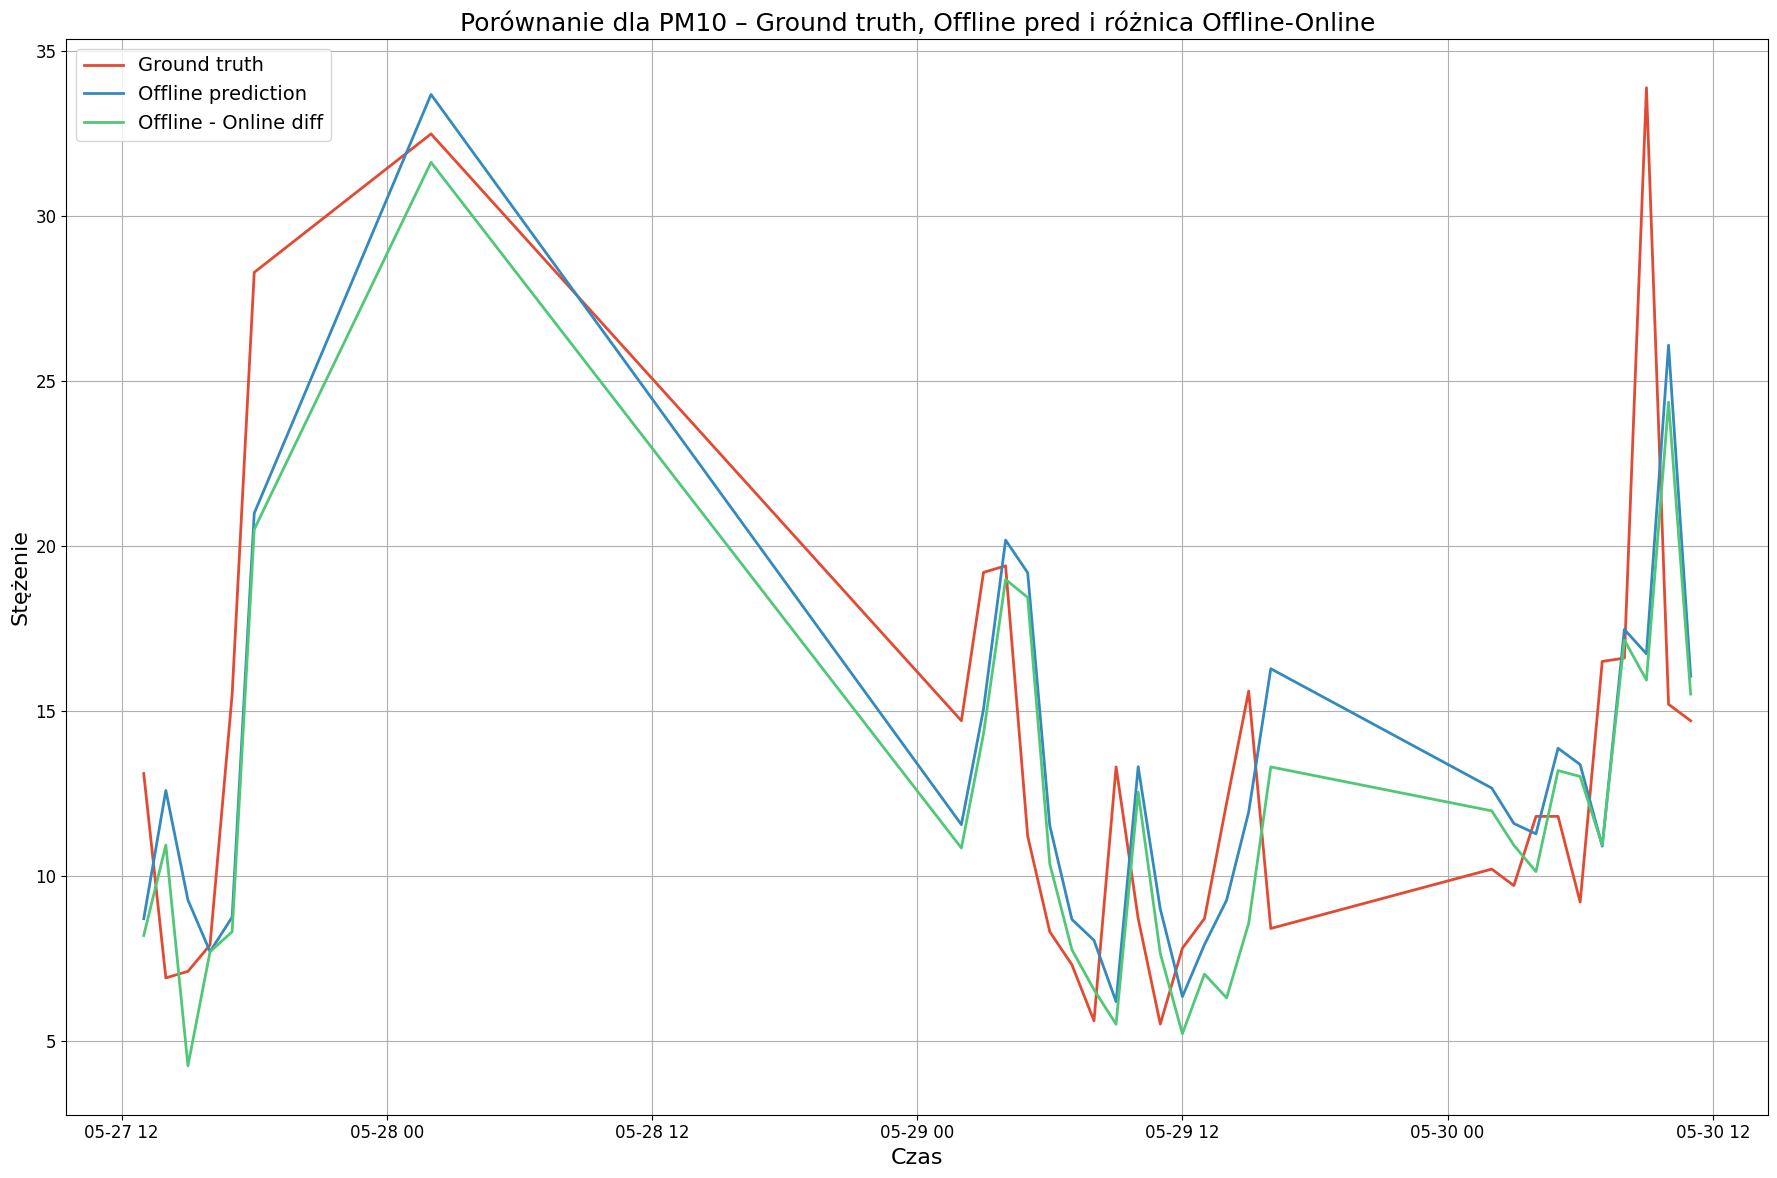

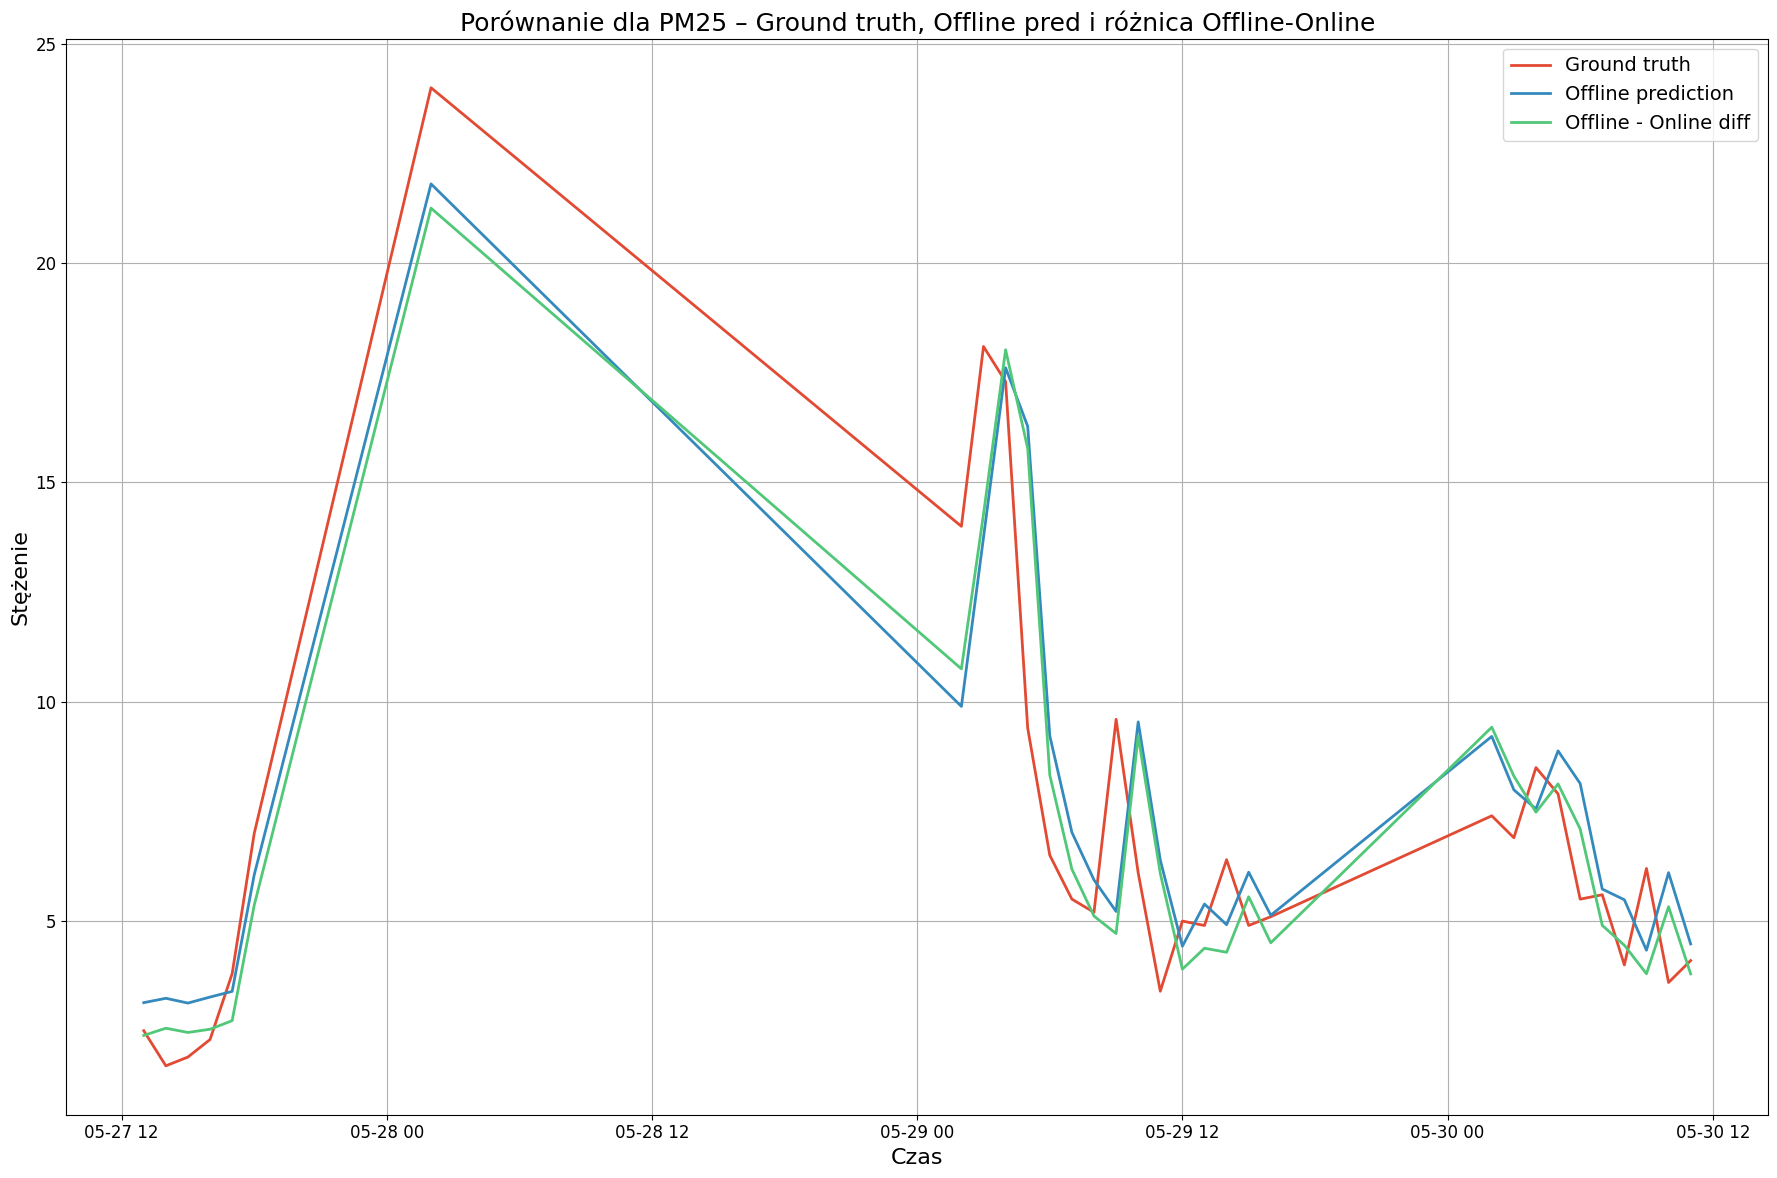

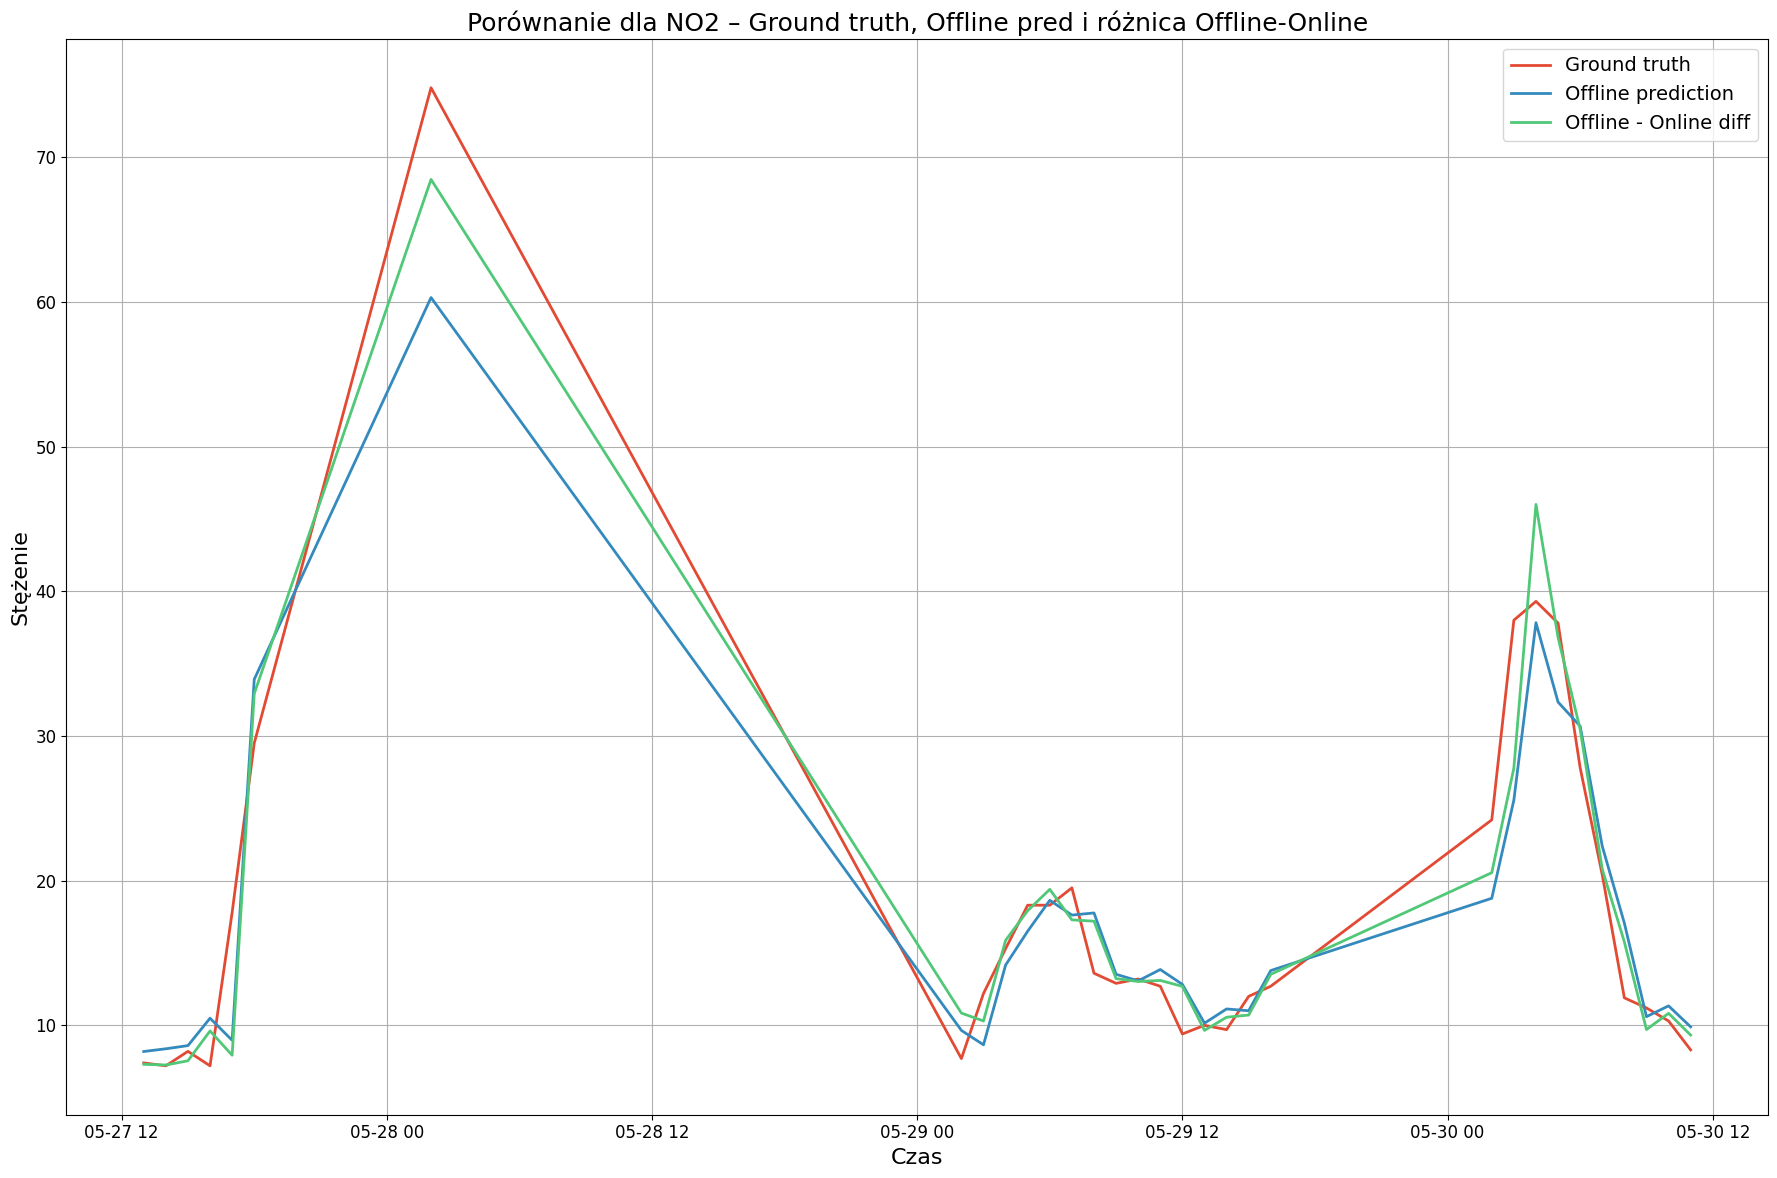

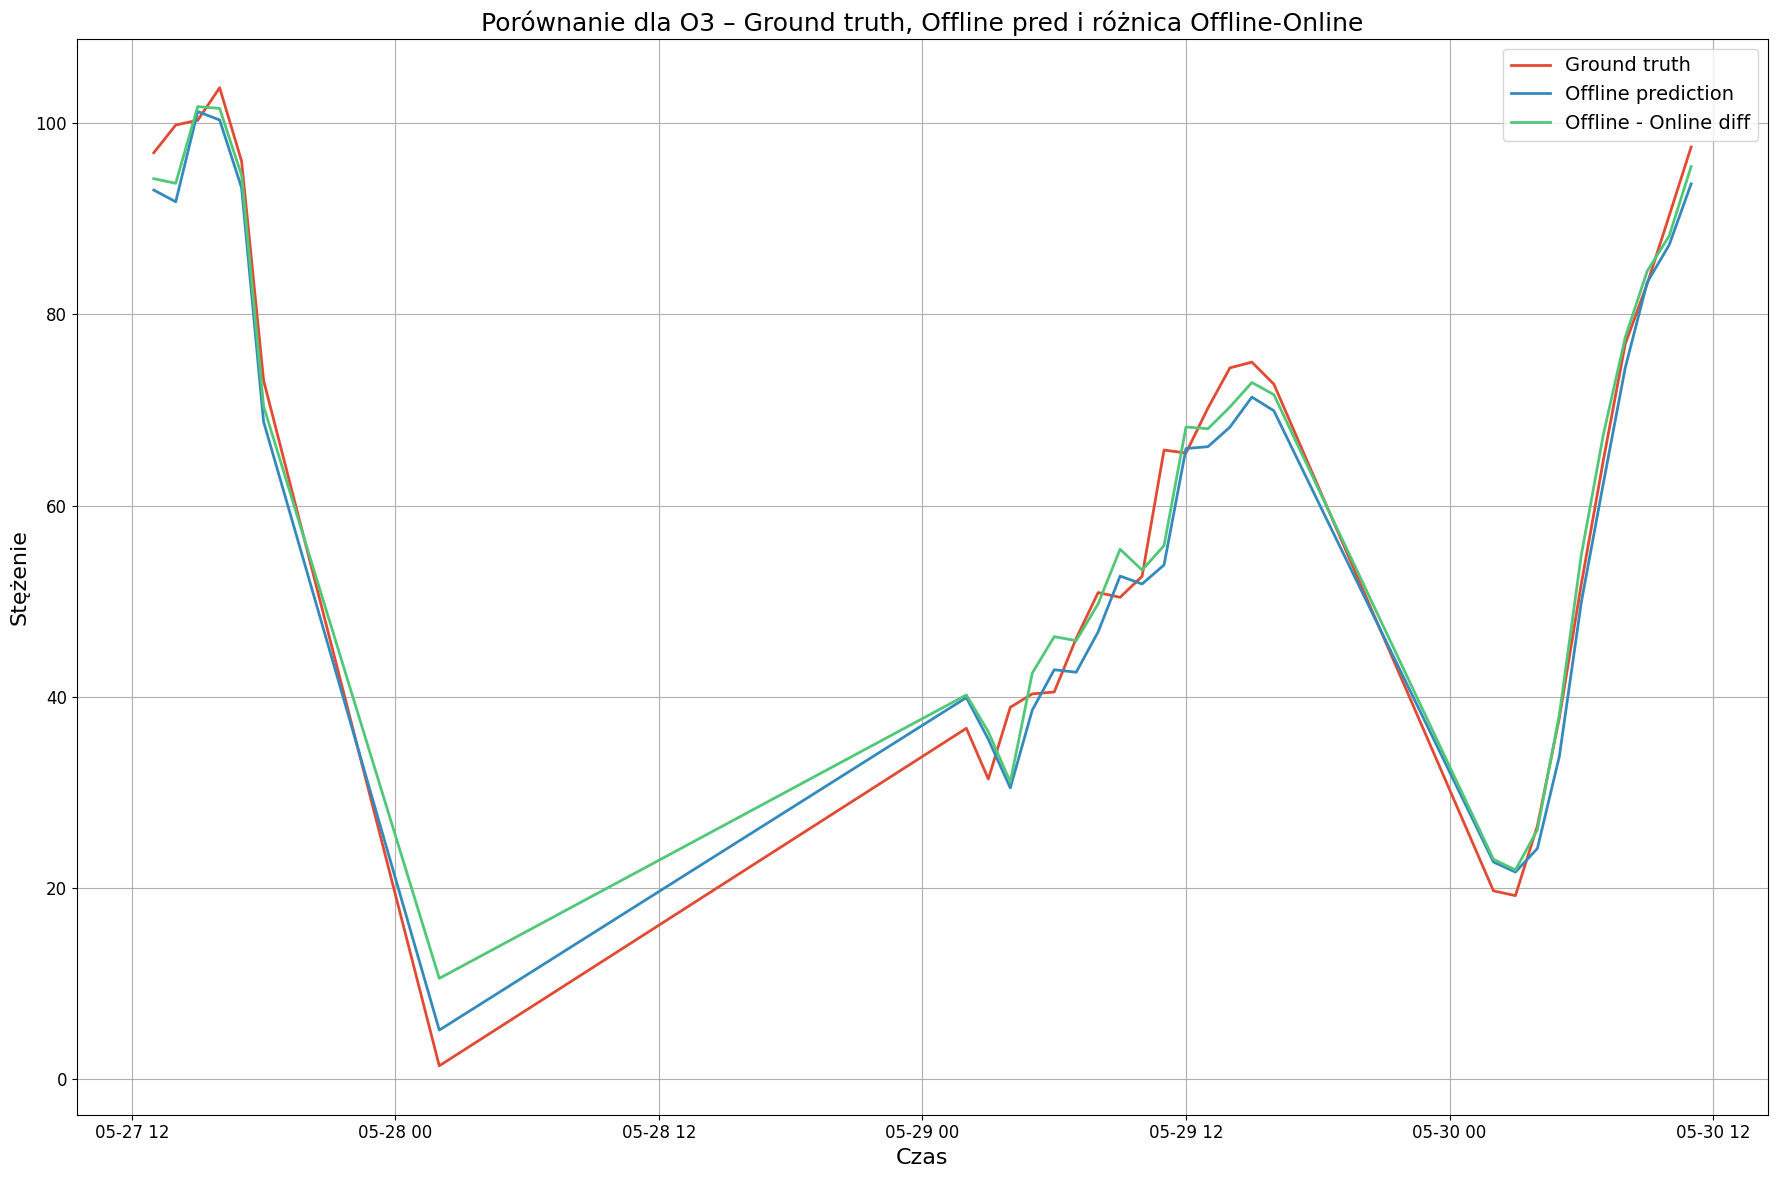

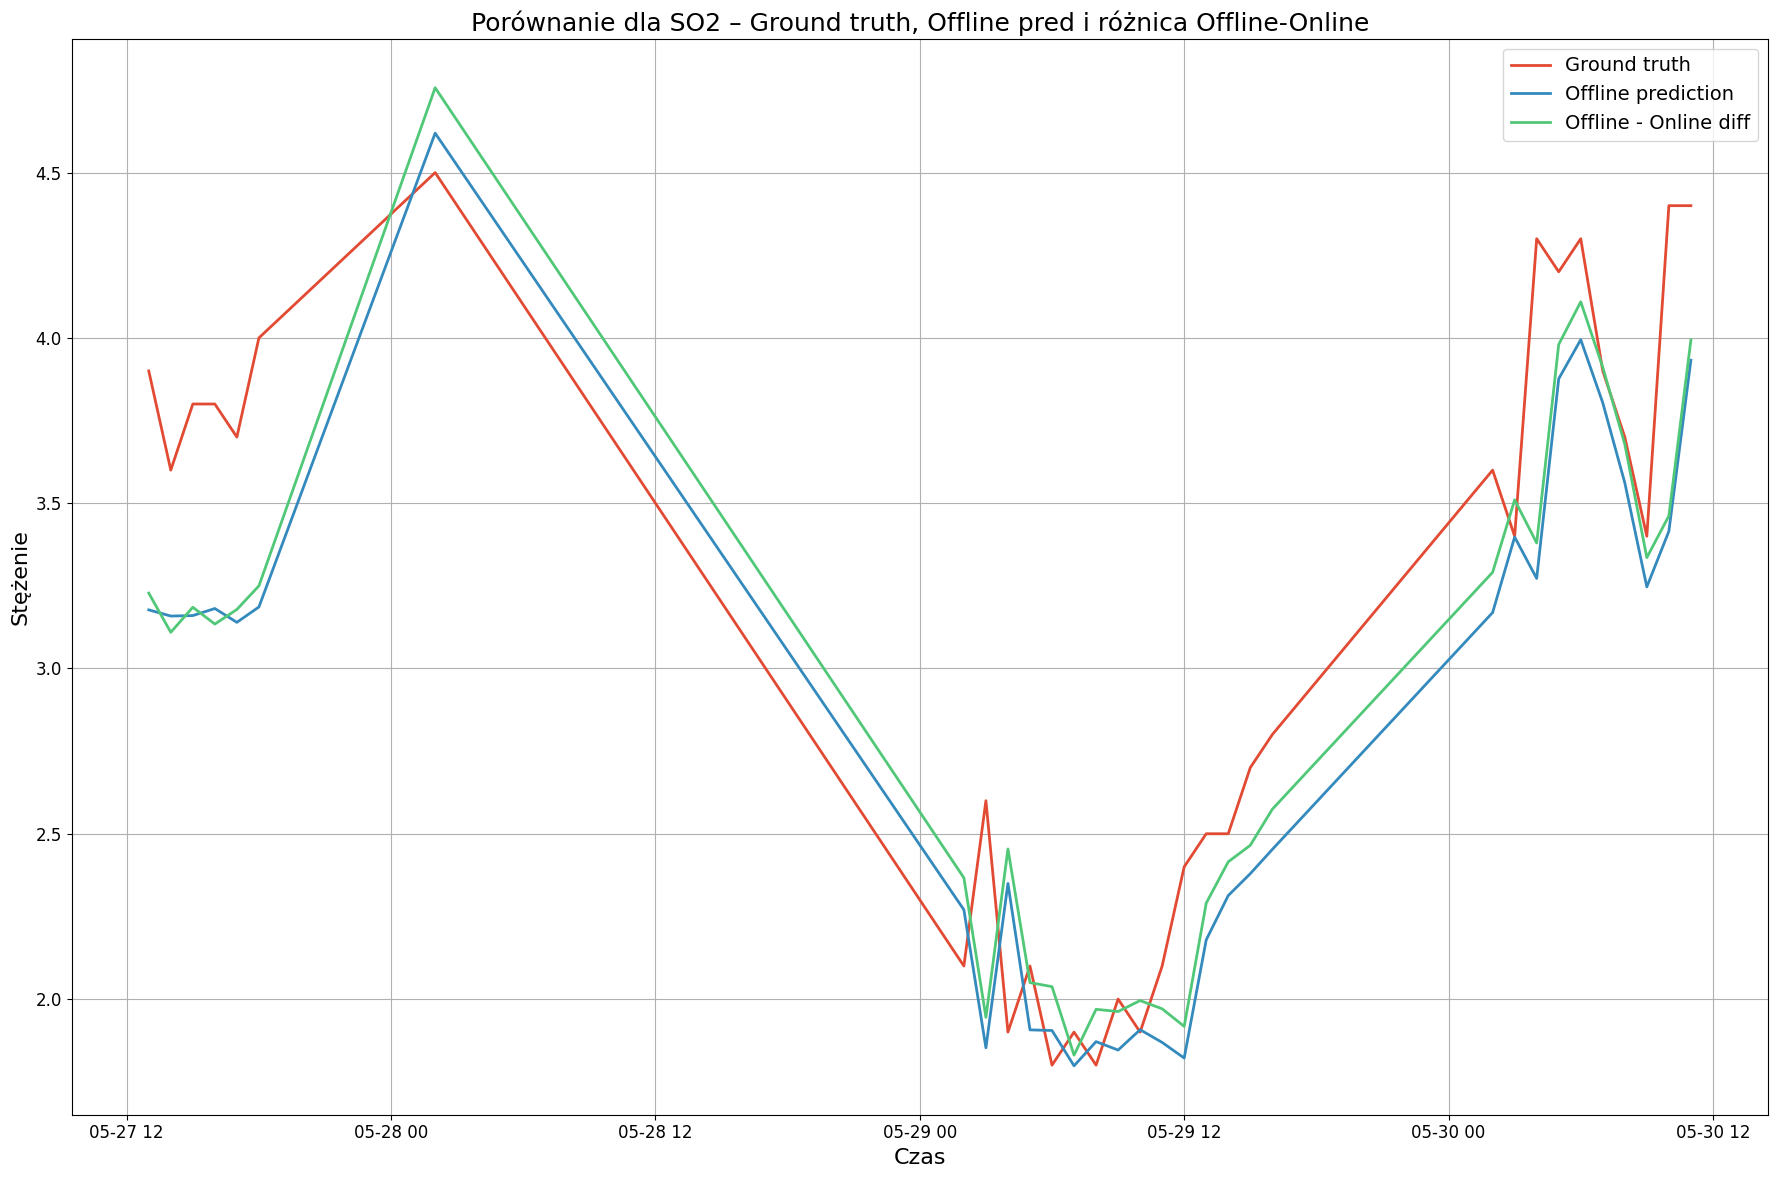

In [ ]:
colors = {
    "gt": "#E24A33",
    "offline": "#348ABD",
    "diff": "#50C878"
}

plt.rcParams.update({'font.size': 14})

OFFLINE_PRED_COLS = {
    "pm10": "offline_model_pred_pm10",
    "pm25": "offline_model_pred_pm25",
    "no2": "offline_model_pred_no2",
    "o3": "offline_model_pred_o3",
    "so2": "offline_model_pred_so2"
}

GROUND_TRUTH_COLS = {
    "pm10": "pm10_t+1",
    "pm25": "pm25_t+1",
    "no2": "no2_t+1",
    "o3": "o3_t+1",
    "so2": "so2_t+1"
}

ONLINE_PRED_COLS = {
    p: f"{p}_online_pred" for p in ["pm10", "pm25", "no2", "o3", "so2"]
}


selected_cols = ["datetime_utc"] + list(GROUND_TRUTH_COLS.values()) + list(OFFLINE_PRED_COLS.values()) + list(ONLINE_PRED_COLS.values())
df_pd = df_online_with_preds.select(*[c for c in selected_cols if c in df_online_with_preds.columns]).toPandas()

df_pd["datetime_utc"] = pd.to_datetime(df_pd["datetime_utc"])
df_pd = df_pd.sort_values("datetime_utc")
df_pd.set_index("datetime_utc", inplace=True)

n_rows = len(df_pd)
test_df_online = df_pd.iloc[int(n_rows * 0.8):]

def line_for_idx(idx):
    if idx == 0:
        return gt
    elif idx == 1:
        return offline
    elif idx == 2:
        return diff
    else:
        raise ValueError("Nieznany indeks linii")

def color_for_idx(idx):
    if idx == 0:
        return colors["gt"]
    elif idx == 1:
        return colors["offline"]
    elif idx == 2:
        return colors["diff"]
    else:
        raise ValueError("Nieznany indeks koloru")

start_date = "2025-05-27"
end_date = "2025-05-31"

mask = (test_df_online.index >= start_date) & (test_df_online.index <= end_date)
test_df_online = test_df_online.loc[mask]

for pollutant in OFFLINE_PRED_COLS.keys():
    gt_col = GROUND_TRUTH_COLS[pollutant]
    offline_col = OFFLINE_PRED_COLS[pollutant]
    online_col = ONLINE_PRED_COLS[pollutant]

    if all(c in test_df_online.columns for c in [gt_col, offline_col, online_col]):
        x = test_df_online.index
        gt = test_df_online[gt_col].values
        offline = test_df_online[offline_col].values
        online = test_df_online[online_col].values

        diff = offline - online

        plt.figure(figsize=(18, 12))
        plt.plot(x, gt, label="Ground truth", color=colors["gt"], linewidth=2)
        plt.plot(x, offline, label="Offline prediction", color=colors["offline"], linewidth=2)
        plt.plot(x, diff, label="Offline - Online diff", color=colors["diff"], linewidth=2)

        for i in range(len(x) - 1):
            points = np.array([
                [gt[i], gt[i+1]],
                [offline[i], offline[i+1]],
                [diff[i], diff[i+1]]
            ])

            order_i = np.argsort(points[:, 0])
            order_i1 = np.argsort(points[:, 1])

            high_idx_i, mid_idx_i, low_idx_i = order_i[2], order_i[1], order_i[0]
            high_idx_i1, mid_idx_i1, low_idx_i1 = order_i1[2], order_i1[1], order_i1[0]

            xs = [x[i], x[i+1]]

        plt.title(f"Porównanie dla {pollutant.upper()} – Ground truth, Offline pred i różnica Offline-Online")
        plt.xlabel("Czas")
        plt.ylabel("Stężenie")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Brakuje danych dla {pollutant} – pomijam.")

In [48]:
from sklearn.metrics import mean_squared_error
import numpy as np

n_rows = len(df_pd)
test_df_online = df_pd.iloc[int(n_rows * 0.2):]

rmse_offline = {}
rmse_diff = {}

for pollutant in OFFLINE_PRED_COLS.keys():
    gt_col = GROUND_TRUTH_COLS[pollutant]
    offline_col = OFFLINE_PRED_COLS[pollutant]
    online_col = ONLINE_PRED_COLS[pollutant]

    if all(c in test_df_online.columns for c in [gt_col, offline_col, online_col]):
        gt = test_df_online[gt_col].values
        offline = test_df_online[offline_col].values
        online = test_df_online[online_col].values

        rmse_offline[pollutant] = np.sqrt(mean_squared_error(gt, offline))
        rmse_diff[pollutant] = np.sqrt(mean_squared_error(gt, offline - online))


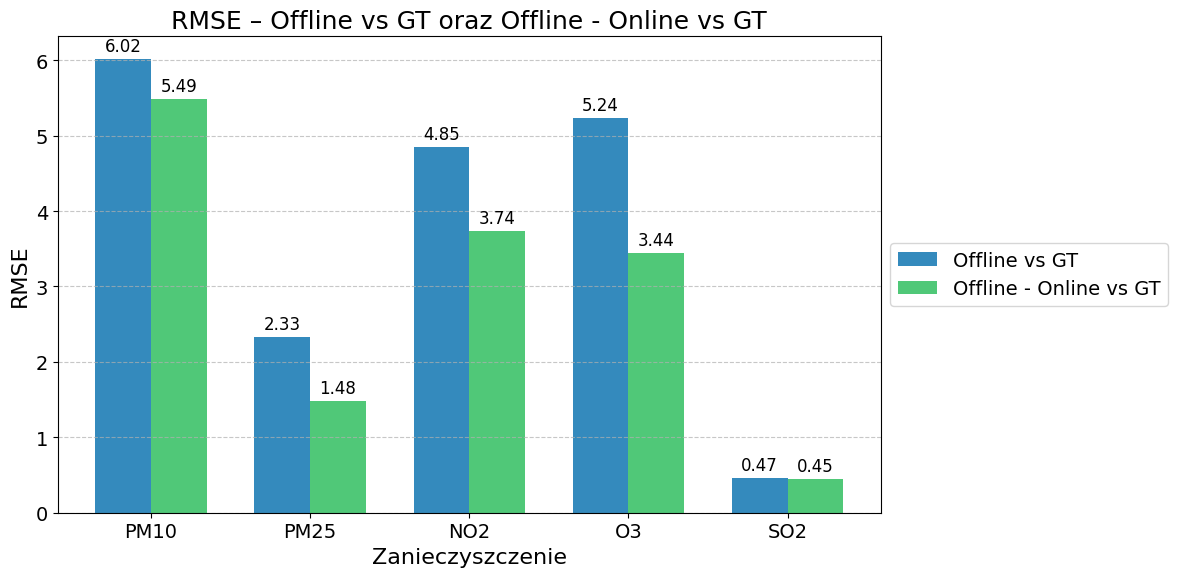

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pollutants = ["pm10", "pm25", "no2", "o3", "so2"]

rmse_offline = []
rmse_diff = []

for pollutant in pollutants:
    gt_col = GROUND_TRUTH_COLS[pollutant]
    offline_col = OFFLINE_PRED_COLS[pollutant]
    online_col = ONLINE_PRED_COLS[pollutant]

    if all(c in test_df_online.columns for c in [gt_col, offline_col, online_col]):
        gt = test_df_online[gt_col].values
        offline = test_df_online[offline_col].values
        online = test_df_online[online_col].values

        diff = offline - online

        rmse_off = mean_squared_error(gt, offline, squared=False)
        rmse_dif = mean_squared_error(gt, diff, squared=False)

        rmse_offline.append(rmse_off)
        rmse_diff.append(rmse_dif)
    else:
        rmse_offline.append(np.nan)
        rmse_diff.append(np.nan)

colors = {
    "offline": "#348ABD",
    "diff": "#50C878"
}

plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(pollutants))

bars1 = plt.bar(x - bar_width / 2, rmse_offline, width=bar_width, label="Offline vs GT", color=colors["offline"])
bars2 = plt.bar(x + bar_width / 2, rmse_diff, width=bar_width, label="Offline - Online vs GT", color=colors["diff"])

for bar in bars1:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=12)

plt.xlabel("Zanieczyszczenie", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.title("RMSE – Offline vs GT oraz Offline - Online vs GT", fontsize=18)
plt.xticks(ticks=x, labels=[p.upper() for p in pollutants], fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [50]:
df_produced = spark.read.format("mongodb").load()
df_produced.show(5)

+--------------------+-----------+-------------------+-----------+------------------+---------------+------------------+-----------------+------------------+------------------+------------------+----+--------+-----+----+-------+----+------+-----------------+----------------------+---------------------+-----------------------+-----------------------+----------------------+-------------------------+------------------------+--------------------------+--------------------------+-------------------------+----+--------+----+--------+-----------------+-------------------+--------+---+-------+------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-----

In [51]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window


df_produced_sorted = df_produced.orderBy("datetime_utc")

df_next = df_produced_sorted.select(
    [F.col(c).alias(c + "_t+1") for c in ["pm10", "pm25", "no2", "o3", "so2"]] + 
    [(F.col("datetime_utc") - F.expr("INTERVAL 1 HOUR")).alias("datetime_utc_t+1")]
)

df_with_next = df_produced_sorted.join(
    df_next,
    df_produced_sorted["datetime_utc"] == df_next["datetime_utc_t+1"],
    how="left"
).drop("datetime_utc_t+1")

df_with_next.orderBy("datetime_utc").show(5)


+--------------------+-----------+-------------------+-----------+------------------+---------------+------------------+-----------------+------------------+------------------+------------------+----+--------+-----+----+-------+----+------+-----------------+----------------------+---------------------+-----------------------+-----------------------+----------------------+-------------------------+------------------------+--------------------------+--------------------------+-------------------------+----+--------+----+--------+-----------------+-------------------+--------+---+-------+------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-----

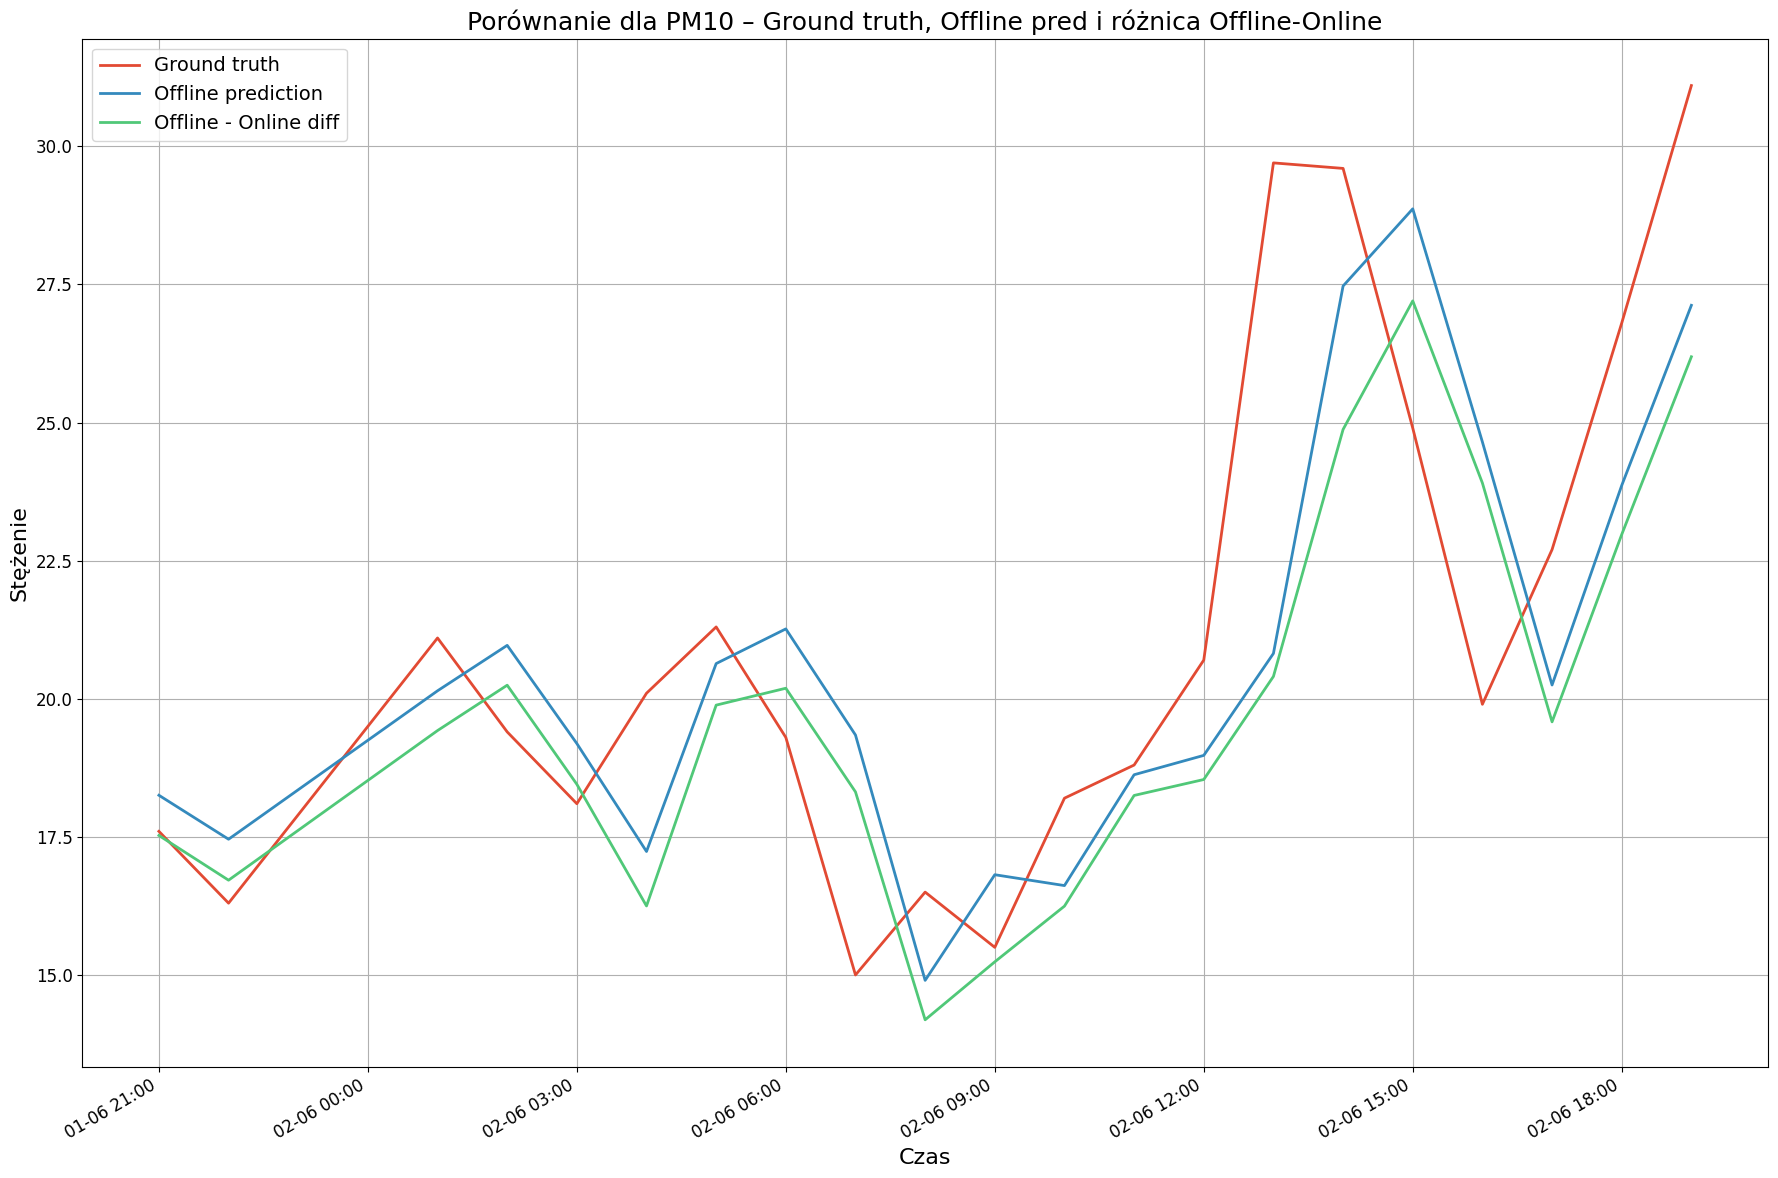

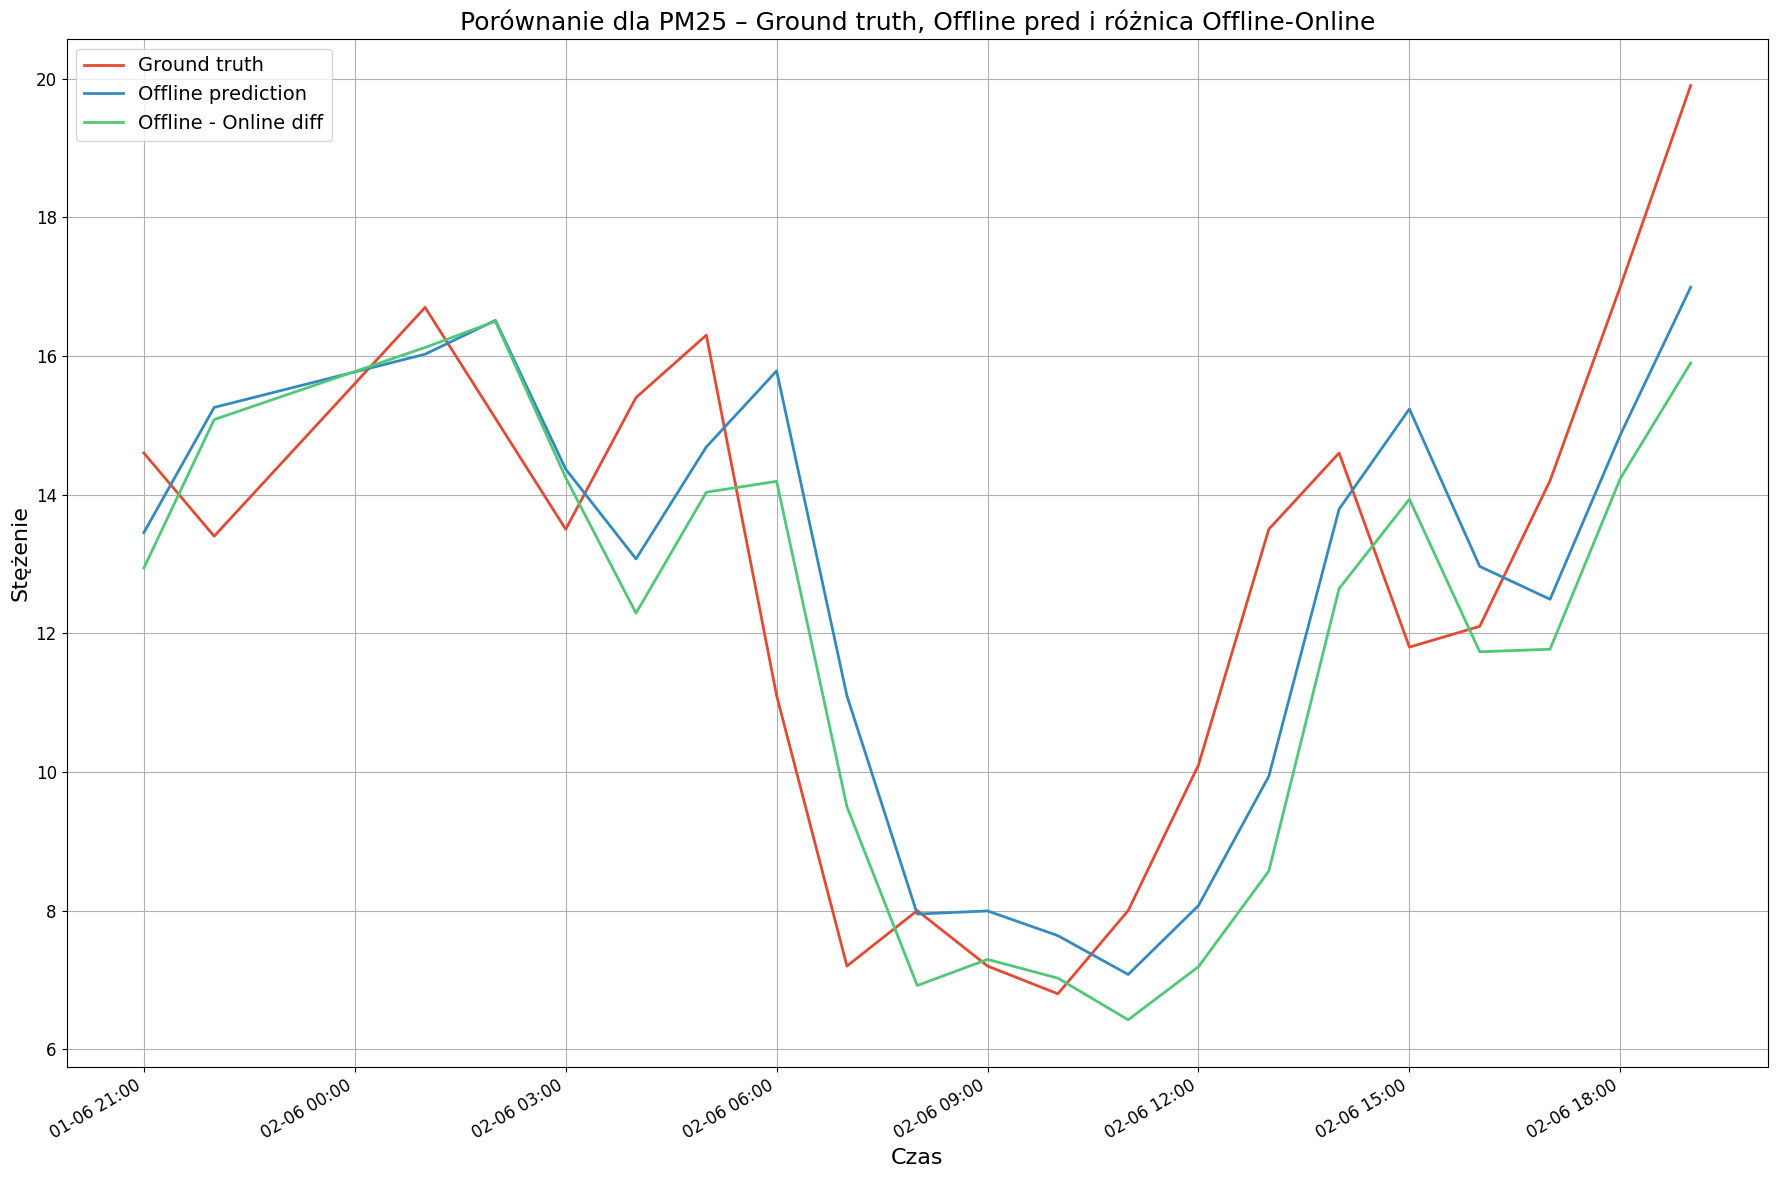

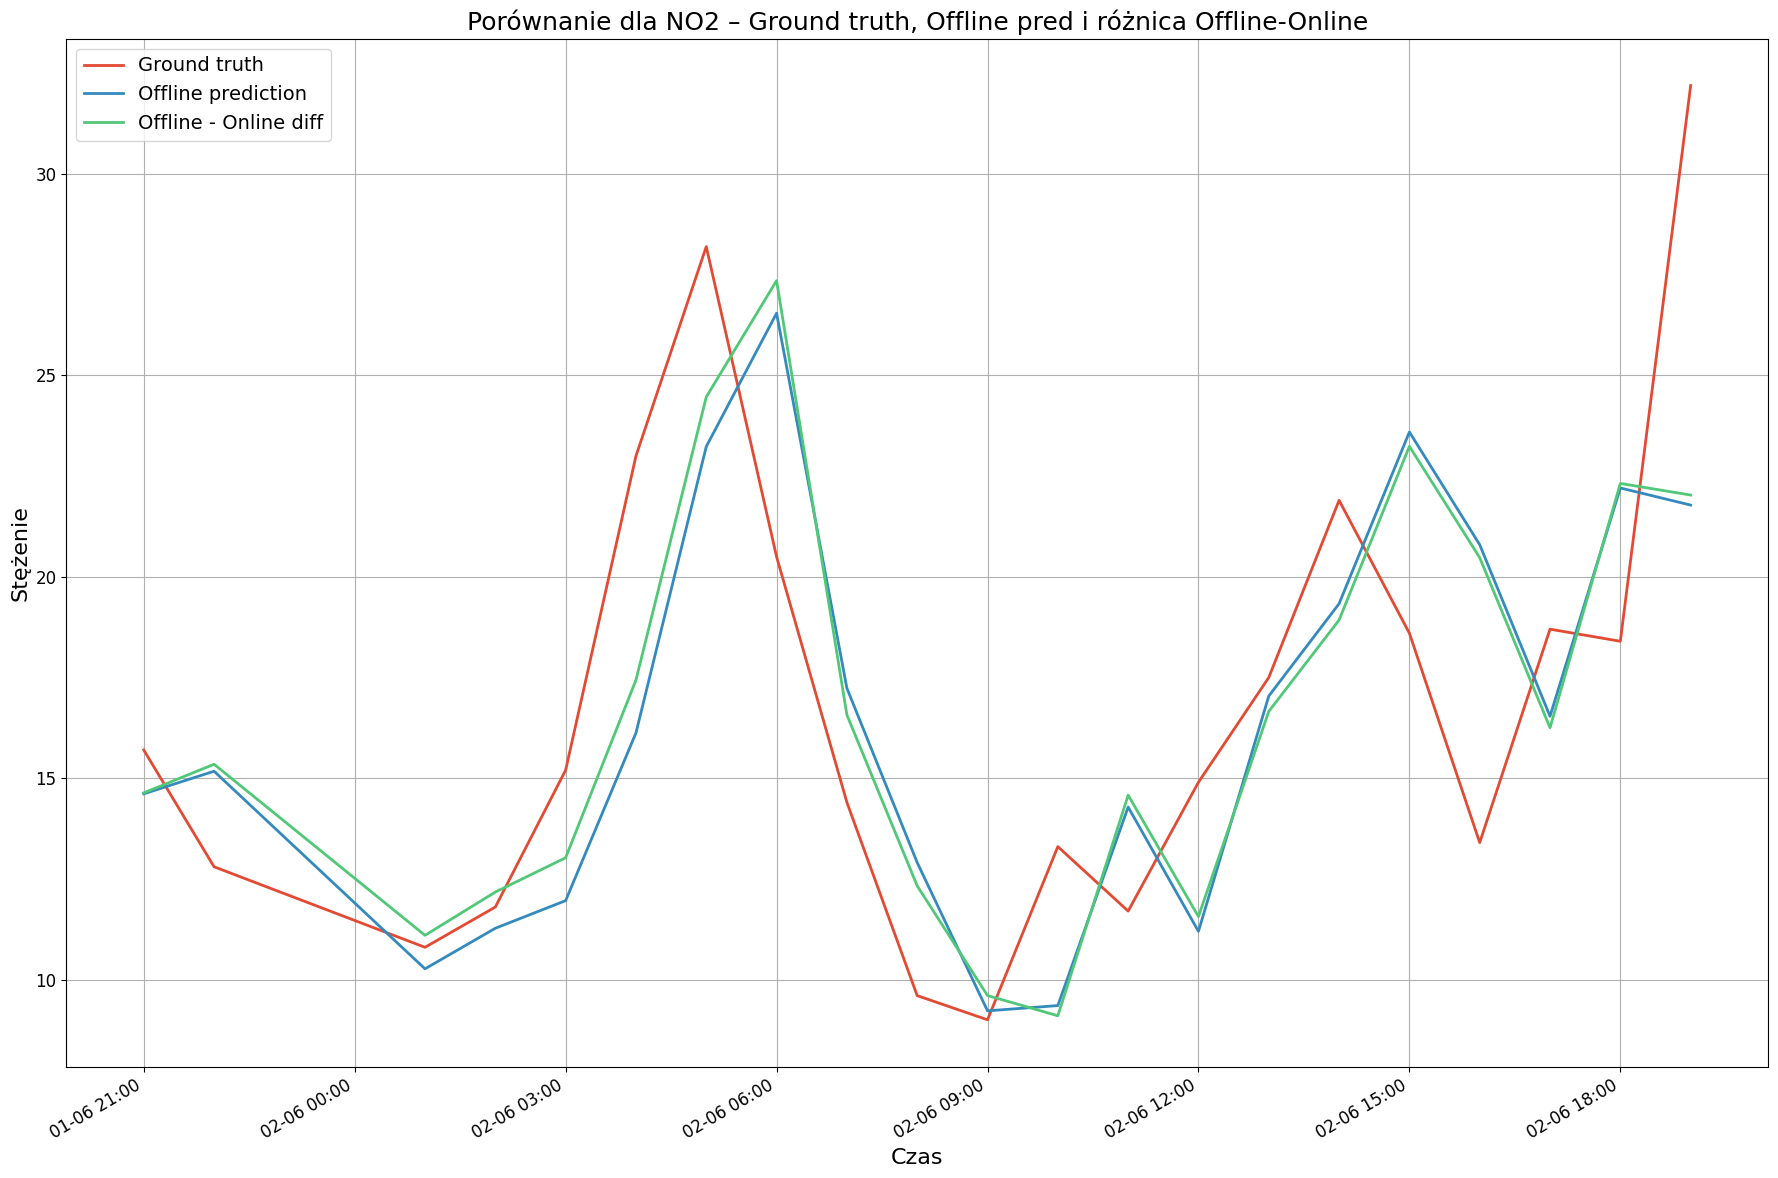

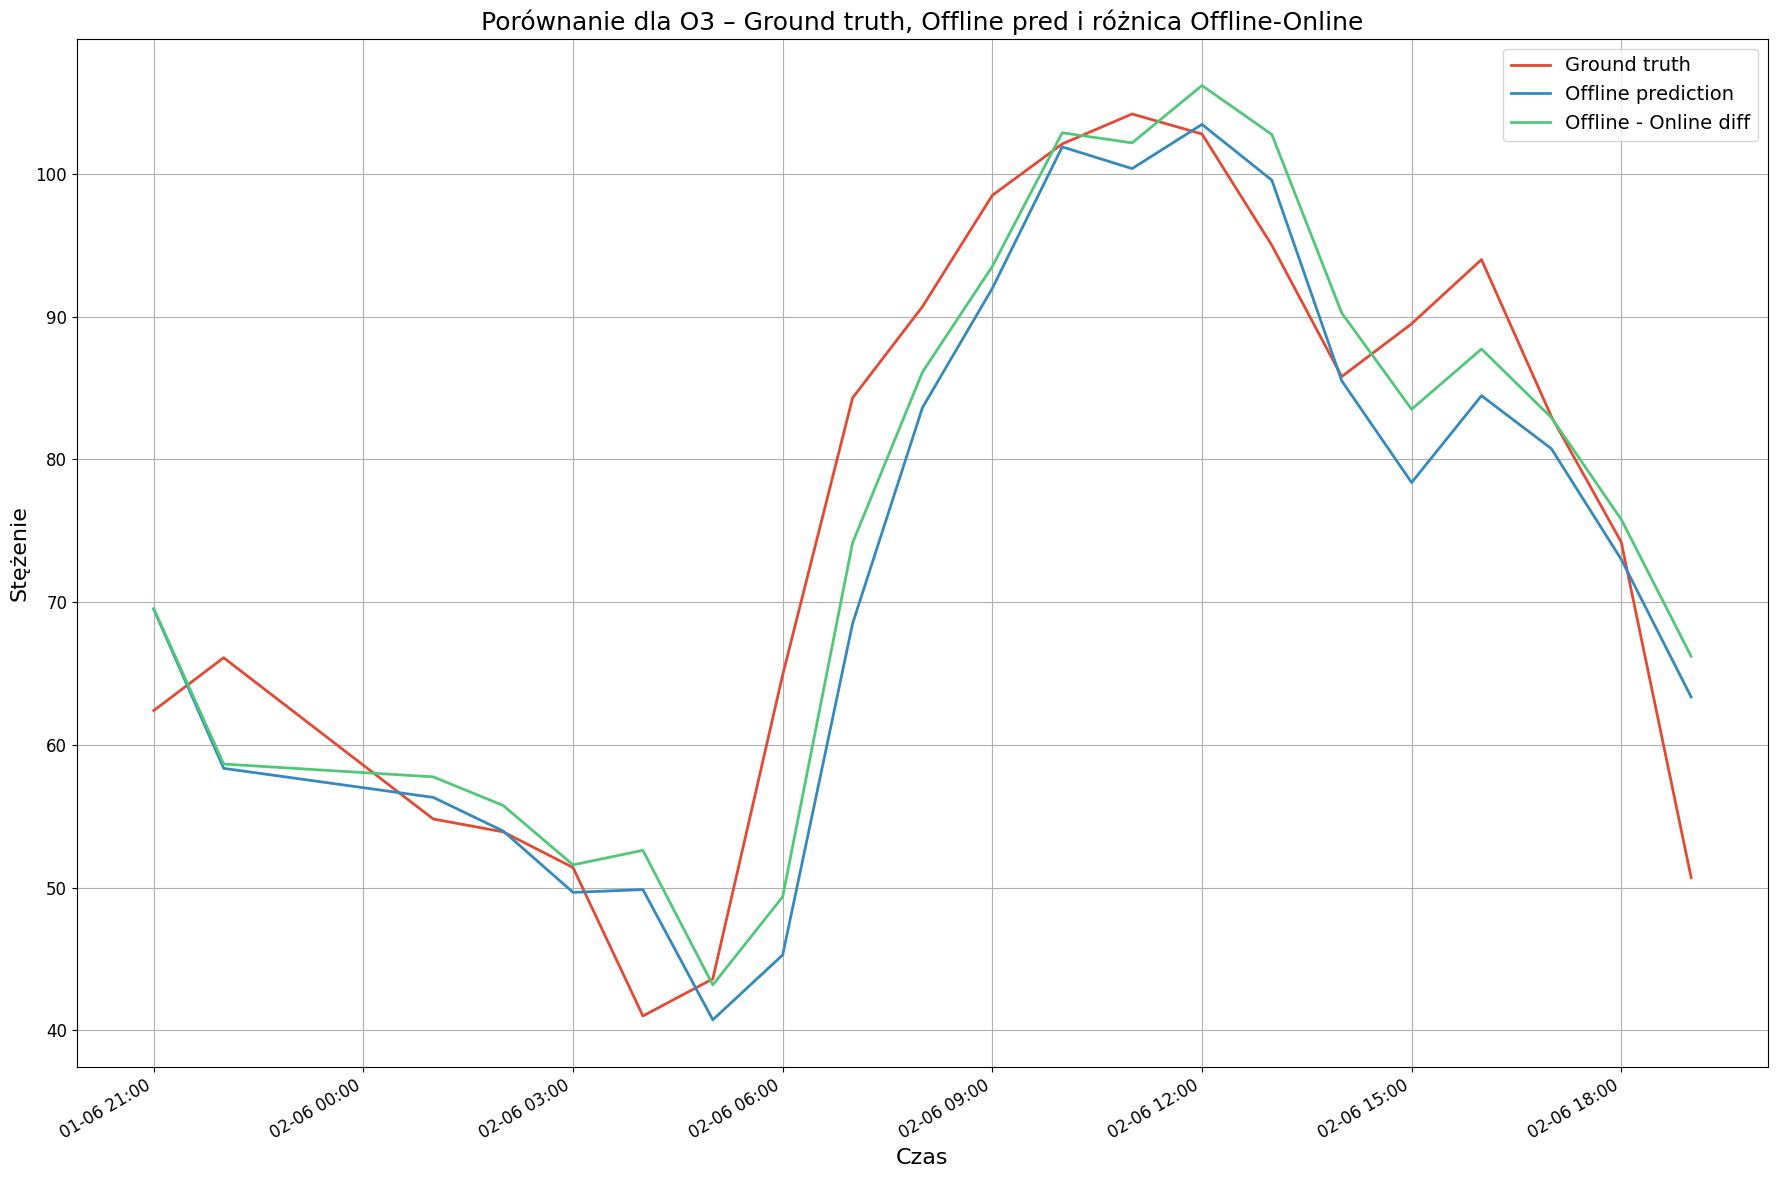

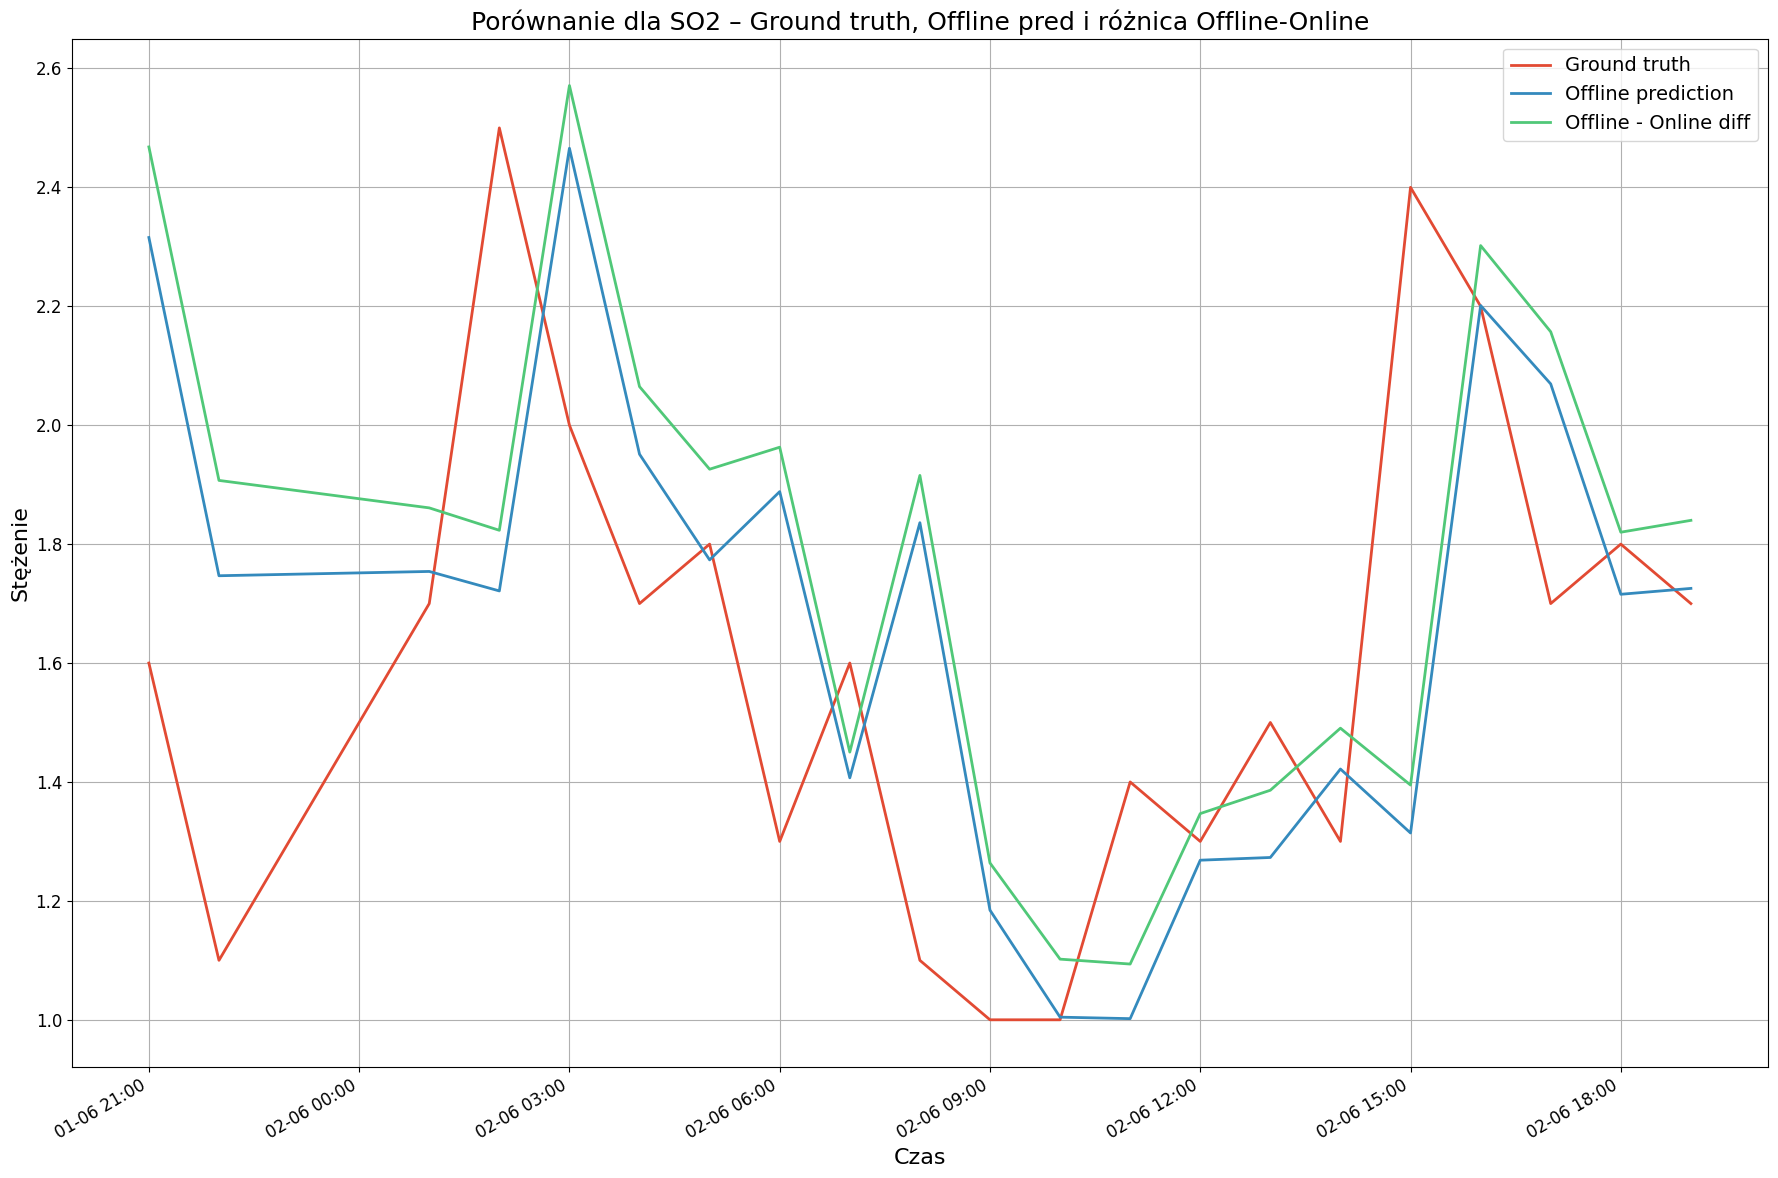

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

colors = {
    "gt": "#E24A33",
    "offline": "#348ABD",
    "diff": "#50C878"
}

plt.rcParams.update({'font.size': 14})

OFFLINE_PRED_COLS = {
    "pm10": "offline_model_pred_pm10",
    "pm25": "offline_model_pred_pm25",
    "no2": "offline_model_pred_no2",
    "o3": "offline_model_pred_o3",
    "so2": "offline_model_pred_so2"
}

GROUND_TRUTH_COLS = {
    "pm10": "pm10_t+1",
    "pm25": "pm25_t+1",
    "no2": "no2_t+1",
    "o3": "o3_t+1",
    "so2": "so2_t+1"
}

ONLINE_PRED_COLS = {
    "pm10": "online_model_pred_res_pm10",
    "pm25": "online_model_pred_res_pm25",
    "no2": "online_model_pred_res_no2",
    "o3": "online_model_pred_res_o3",
    "so2": "online_model_pred_res_so2"
}

FINAL_PRED_COLS = {
    "pm10": "final_pred_pm10",
    "pm25": "final_pred_pm25",
    "no2": "final_pred_no2",
    "o3": "final_pred_o3",
    "so2": "final_pred_so2"
}

selected_cols = ["datetime_utc"] + \
                list(GROUND_TRUTH_COLS.values()) + \
                list(OFFLINE_PRED_COLS.values()) + \
                list(ONLINE_PRED_COLS.values()) + \
                list(FINAL_PRED_COLS.values()) 

available_cols = [c for c in selected_cols if c in df_with_next.columns]

pollutant_cols = ['pm10_t+1', 'pm25_t+1', 'no2_t+1', 'o3_t+1',  'so2_t+1']

df_pd = df_with_next.select(*available_cols).toPandas()
df_pd = df_pd.dropna(subset=pollutant_cols)
df_pd["datetime_utc"] = pd.to_datetime(df_pd["datetime_utc"])
df_pd = df_pd.sort_values("datetime_utc").set_index("datetime_utc")

test_df_real_time = df_pd.copy()
test_df_real_time = test_df_real_time.iloc[:-1,:]
def line_for_idx(idx, gt, offline, diff):
    if idx == 0:
        return gt
    elif idx == 1:
        return offline
    elif idx == 2:
        return diff
    else:
        raise ValueError("Nieznany indeks linii")

def color_for_idx(idx):
    if idx == 0:
        return colors["gt"]
    elif idx == 1:
        return colors["offline"]
    elif idx == 2:
        return colors["diff"]
    else:
        raise ValueError("Nieznany indeks koloru")

for pollutant in OFFLINE_PRED_COLS.keys():
    gt_col = GROUND_TRUTH_COLS[pollutant]
    offline_col = OFFLINE_PRED_COLS[pollutant]
    online_col = ONLINE_PRED_COLS[pollutant]

    if all(c in test_df_real_time.columns for c in [gt_col, offline_col, online_col]):
        x = test_df_real_time.index
        gt = test_df_real_time[gt_col].values
        offline = test_df_real_time[offline_col].values
        online = test_df_real_time[online_col].values

        diff = offline - online

        plt.figure(figsize=(18, 12))
        plt.plot(x, gt, label="Ground truth", color=colors["gt"], linewidth=2)
        plt.plot(x, offline, label="Offline prediction", color=colors["offline"], linewidth=2)
        plt.plot(x, diff, label="Offline - Online diff", color=colors["diff"], linewidth=2)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
        plt.gcf().autofmt_xdate()

        plt.title(f"Porównanie dla {pollutant.upper()} – Ground truth, Offline pred i różnica Offline-Online")
        plt.xlabel("Czas")
        plt.ylabel("Stężenie")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Brakuje danych dla {pollutant} – pomijam.")


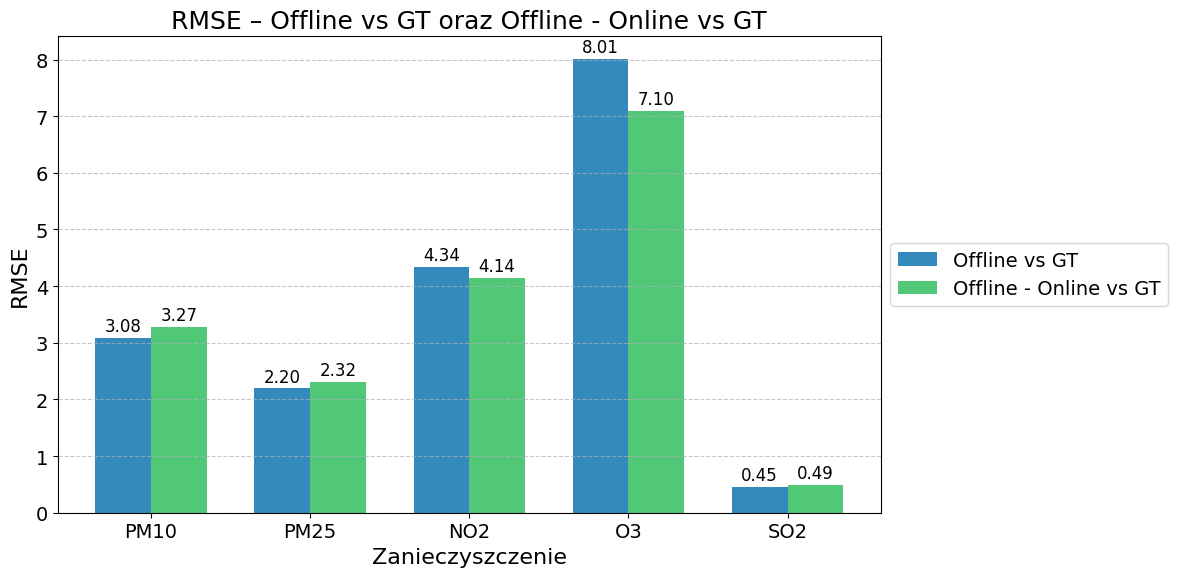

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pollutants = ["pm10", "pm25", "no2", "o3", "so2"]

rmse_offline = []
rmse_diff = []

for pollutant in pollutants:
    gt_col = GROUND_TRUTH_COLS[pollutant]
    offline_col = OFFLINE_PRED_COLS[pollutant]
    online_col = ONLINE_PRED_COLS[pollutant]

    if all(c in test_df_real_time.columns for c in [gt_col, offline_col, online_col]):
        gt = test_df_real_time[gt_col].values
        offline = test_df_real_time[offline_col].values
        online = test_df_real_time[online_col].values

        diff = offline - online

        rmse_off = mean_squared_error(gt, offline, squared=False)
        rmse_dif = mean_squared_error(gt, diff, squared=False)

        rmse_offline.append(rmse_off)
        rmse_diff.append(rmse_dif)
    else:
        rmse_offline.append(np.nan)
        rmse_diff.append(np.nan)

colors = {
    "offline": "#348ABD",
    "diff": "#50C878"
}

plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(pollutants))

bars1 = plt.bar(x - bar_width / 2, rmse_offline, width=bar_width, label="Offline vs GT", color=colors["offline"])
bars2 = plt.bar(x + bar_width / 2, rmse_diff, width=bar_width, label="Offline - Online vs GT", color=colors["diff"])

for bar in bars1:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=12)

for bar in bars2:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=12)

plt.xlabel("Zanieczyszczenie", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.title("RMSE – Offline vs GT oraz Offline - Online vs GT", fontsize=18)
plt.xticks(ticks=x, labels=[p.upper() for p in pollutants], fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
